# Preprocessing Setup
Basic steps, because there are domain specific problems to account for later

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import pkg_resources
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, wordnet, brown

In [ ]:
# !pip install symspellpy

from spacy.cli import download
download('en_core_web_md')
nltk.download('words')
nltk.download('omw-1.4')
nltk.download('wordnet')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# from symspellpy import SymSpell, Verbosity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
reviews = pd.read_csv("/content/drive/MyDrive/RMP/reviews_filtered.csv").sample(n=300000, random_state=1)
# reviews = pd.read_csv("/content/drive/MyDrive/RMP/scraped_comments_with_professor.csv").sample(n=300000, random_state=1)
# reviews[['comment_id', 'firstName', 'lastName', 'prof_class', 'comment', 'clarityRating', 'helpfulRating']].to_csv("/content/drive/MyDrive/RMP/scraped_comments_sample.csv")

In [ ]:
reviews.head()

,Unnamed: 0,firstName,lastName,prof_class,comment,date,clarityRating,helpfulRating,professor_id,comment_id,qualityRating,sentiment
307424,843276,Corey,Zwikstra,EN310,He is clearly well versed on the topic. Howeve...,2012-12-02 17:52:09+00:00,1,1,VGVhY2hlci0xMjY4MTU4,UmF0aW5nLTIwOTMxNjI3,1.0,False
265217,835083,Jeff,Thompson,FINA445,Really nice guy but the class was terrible. He...,2007-11-19 14:13:32+00:00,3,4,VGVhY2hlci0xMDUzMDc2,UmF0aW5nLTEzNjc4MTc2,3.5,True
140855,215011,Danney,Ursery,PHIL119,This instructor is wonderful! If you need help...,2009-05-10 19:55:20+00:00,4,5,VGVhY2hlci05OTEzODg=,UmF0aW5nLTE1ODA3MDAx,4.5,True
181201,610297,Cheira,Belguellaoui,FREN420,I didn't know anything about the Maghreb and ...,2008-12-06 22:25:06+00:00,5,5,VGVhY2hlci05NDc4MjA=,UmF0aW5nLTE1MTIyMDM0,5.0,True
143393,547933,Paul,Koester,MA123,"Paul is a pretty good teacher, pay attention i...",2011-07-28 21:01:05+00:00,4,4,VGVhY2hlci0xMzE5NjA0,UmF0aW5nLTE4ODYxMzg1,4.0,True


## Duplicates and Nulls

In [ ]:
print("Shape before dropping:", reviews.shape)
reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

# drop rows containing only "No Comments" (default value assigned by RMP to a review that didn't enter a comment)
reviews = reviews[reviews["comment"] != "No Comments"]

# drop rows containing NaN comment
reviews.dropna(subset=["comment"], inplace=True)

# fill null names with empty string
reviews['firstName'].fillna('', inplace=True)
reviews['lastName'].fillna('', inplace=True)

# Dropping qualityRating == 3.0
reviews['qualityRating'] = (reviews['helpfulRating']+reviews['clarityRating'])/2.0
reviews = reviews[reviews["qualityRating"] != 3.0]
reviews["sentiment"] = reviews["qualityRating"] > 3.0

print("Shape after dropping:", reviews.shape)
reviews.reset_index(drop=True, inplace=True)

Shape before dropping: (300000, 12)
Shape after dropping: (300000, 12)


## Removing Urls, Phone Numbers, and Emails

In [ ]:
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', ' ', text)

def remove_phones(text):
    return re.sub(r'\d{3}-\d{3}-\d{4}', ' ', text)

def remove_emails(text):
    return re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', ' ', text)

print(remove_urls('Hey! Check out this link: www.somelink.com'))
print(remove_phones("Hey! Check out this phone number: 742-457-0417"))
print(remove_emails("Hey! Check out this email address: nooneuses@yahoo.com"))

Hey! Check out this link:  
Hey! Check out this phone number:  
Hey! Check out this email address:  


## Html Artifacts

In [ ]:
# TODO: Convert html entites of quotes -> "'" to normalize
def remove_html_entities(text):
  text = re.sub('&[0-9a-zA-Z#]+;', ' ', text)
  return re.sub('&#63;?', '', text)

def remove_html_tags(text):
  return re.sub('<.{1,6}?>', ' ', text)

text = "This professor is such an easy &quot;A&quot;, why are y'all struggling &#63;&#63;&#63 </div>"
print(remove_html_entities(text))
print(remove_html_tags(text))

This professor is such an easy  A , why are y'all struggling    </div>
This professor is such an easy &quot;A&quot;, why are y'all struggling &#63;&#63;&#63  


## Emoticon Conversion to Words

In [ ]:
#@title Emoticon Mapping
EMOTICONS = {
    u"<3": "emopos",
    u":‑)":"emopos",
    u":-))":"emopos",
    u":-)))":"emopos",
    u":)":"emopos",
    u":))":"emopos",
    u":)))":"emopos",
    u":-]":"emopos",
    u":]":"emopos",
    u":-3":"emopos",
    u":3":"emopos",
    u":->":"emopos",
    u":>":"emopos",
    u"8-)":"emopos",
    u":-}":"emopos",
    u":}":"emopos",
    u":-)":"emopos",
    u":c)":"emopos",
    u":^)":"emopos",
    u"=]":"emopos",
    u"=)":"emopos",
    u":‑D":"emopos",
    u":D":"emopos",
    u"8‑D":"emopos",
    u"8D":"emopos",
    u"X‑D":"emopos",
    u"XD":"emopos",
    u"=D":"emopos",
    u"=3":"emopos",
    u"B^D":"emopos",
    u":-))":"emopos",
    u":-(":"emoneg",
    u":‑(":"emoneg",
    u":(":"emoneg",
    u":‑c":"emoneg",
    u":c":"emoneg",
    u":‑<":"emoneg",
    u":<":"emoneg",
    u":‑[":"emoneg",
    u":[":"emoneg",
    u":-||":"emoneg",
    u">:[":"emoneg",
    u":{":"emoneg",
    u">:(":"emoneg",
    u":'‑(":"emoneg",
    u":'(":"emoneg",
    u":'‑)":"emopos",
    u":')":"emopos",
    u"D‑':":"emoneg",
    u"D:<":"emoneg",
    u"D:":"emoneg",
    u"D8":"emoneg",
    u"D;":"emoneg",
    u"D=":"emoneg",
    u"DX":"emoneg",
    u";‑)":"emopos",
    u";)":"emopos",
    u"*-)":"emopos",
    u"*)":"emopos",
    u";‑]":"emopos",
    u";]":"emopos",
    u";^)":"emopos",
    u":‑,":"emopos",
    u";D":"emopos",
    u":‑P":"emopos",
    u":P":"emopos",
    u"X‑P":"emopos",
    u"XP":"emopos",
    u":‑Þ":"emopos",
    u":Þ":"emopos",
    u"=p":"emopos",
    u":‑/":"emoneg",
    u":/":"emoneg",
    u":-[.]":"emoneg",
    u">:[(\)]":"emoneg",
    u">:/":"emoneg",
    u":[(\)]":"emoneg",
    u"=/":"emoneg",
    u"=[(\)]":"emoneg",
    u":L":"emoneg",
    u"=L":"emoneg",
    u":‑|":"emoneg",
    u":|":"emoneg",
    u"O:‑)":"emopos",
    u"O:)":"emopos",
    u"0:‑3":"emopos",
    u"0:3":"emopos",
    u"0:‑)":"emopos",
    u"0:)":"emopos",
    u":‑b":"emopos",
    u"(>_<)":"emoneg",
    u"(>_<)>":"emoneg",
    u"^_^":"emopos",
    u"(^_^)/":"emopos",
    u"(^O^)／":"emopos",
    u"(^o^)／":"emopos",
    u"('_')":"emoneg",
    u"(/_;)":"emoneg",
    u"(T_T) (;_;)":"emoneg",
    u"(;_;":"emoneg",
    u"(;_:)":"emoneg",
    u"(;O;)":"emoneg",
    u"(:_;)":"emoneg",
    u"(ToT)":"emoneg",
    u";_;":"emoneg",
    u";-;":"emoneg",
    u";n;":"emoneg",
    u"Q.Q":"emoneg",
    u"T.T":"emoneg",
    u"Q_Q":"emoneg",
    u"(-.-)":"emopos",
    u"(-_-)":"emopos",
    u"(；一_一)":"emopos",
    u"(=_=)":"emoneg",
    u"^m^":"emopos",
    u">^_^<":"emopos",
    u"<^!^>":"emopos",
    u"^/^":"emopos",
    u"（*^_^*）" :"emopos",
    u"(^<^) (^.^)":"emopos",
    u"(^^)":"emopos",
    u"(^.^)":"emopos",
    u"(^_^.)":"emopos",
    u"(^_^)":"emopos",
    u"(^^)":"emopos",
    u"(^J^)":"emopos",
    u"(*^.^*)":"emopos",
    u"(^—^）":"emopos",
    u"(#^.^#)":"emopos",
    u"(*^0^*)":"emopos",
    u"(*^^)v":"emopos",
    u"(^_^)v":"emopos",
    u'(-"-)':"emoneg",
    u"(ーー;)":"emoneg",
    u"(＾ｖ＾)":"emopos",
    u"(＾ｕ＾)":"emopos",
    u"(^)o(^)":"emopos",
    u"(^O^)":"emopos",
    u"(^o^)":"emopos",
    u")^o^(":"emopos",
    u":O o_O":"emoneg",
    u"o_0":"emoneg",
    u"o.O":"emoneg",
    u"(o.o)":"emoneg",
    u"(*￣m￣)": "emoneg",
}

for emote, val in EMOTICONS.items():
  EMOTICONS[emote] = val.lower().replace(',', ' ').replace(' ', '_')

In [ ]:
def convert_emoticons(text):
  return EMOTICONS.get(text, text)
  
text = "Hello :-) :-)"
text_split = text.split()
for i, txt in enumerate(text_split):
  text_split[i] = convert_emoticons(txt)
print(' '.join(text_split))

Hello emopos emopos


## Contractions

In [ ]:
#@title Contraction Mapping
contraction_mapping = {
    "dont": "do not",
    "doesnt": "does not",
    "arent": "are not",
    "cant": "can not",
    "couldve": "could have",
    "couldnt": "could not",
    "didnt": "did not",
    "aint": "is not",
    "arent": "are not",
    "hes": "he is",
    "shes": "she is",
    "havent": "have not",
    "hasnt": "has not",
    'youll': "you will",
    "ive": "i have",
    "youve": "you have",
    "shouldve": "should have",
    "im": "i am",
    "isnt": "is not",
    "ain't": "is not", 
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because", 
    "could've": "could have", 
    "couldn't": "could not", 
    "didn't": "did not",  
    "doesn't": "does not", 
    "don't": "do not", 
    "hadn't": "had not", 
    "hasn't": "has not", 
    "shouldnt": "should not",
    "haven't": "have not", 
    "he'd": "he would",
    "he'll": "he will", 
    "he's": "he is", 
    "how'd": "how did", 
    "how'd'y": "how do you", 
    "how'll": "how will", 
    "how's": "how is",
    "i'd": "i would", 
    "i'd've": "i would have", 
    "i'll": "i will",  
    "i'll've": "i will have",
    "i'm": "i am", 
    "i've": "i have", 
    "isn't": "is not", 
    "it'd": "it would", 
    "it'd've": "it would have", 
    "it'll": "it will", 
    "it'll've": "it will have",
    "it's": "it is", 
    "let's": "let us", 
    "ma'am": "madam", 
    "mayn't": "may not", 
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have", 
    "must've": "must have", 
    "mustn't": "must not", 
    "mustn't've": "must not have", 
    "needn't": "need not", 
    "needn't've": "need not have",
    "o'clock": "of the clock", 
    "oughtn't": "ought not", 
    "oughtn't've": "ought not have", 
    "shan't": "shall not", 
    "sha'n't": "shall not", 
    "shan't've": "shall not have", 
    "she'd": "she would", 
    "she'd've": "she would have", 
    "she'll": "she will", 
    "she'll've": "she will have", 
    "she's": "she is", 
    "should've": "should have", 
    "shouldn't": "should not", 
    "shouldn't've": "should not have", 
    "this's": "this is",
    "this'll": "this will",
    "thisll": "this will",
    "that'd": "that would", 
    "that'd've": "that would have", 
    "that's": "that is", 
    "thats": "that is",
    "there'd": "there would", 
    "there'd've": "there would have", 
    "there's": "there is", 
    "theres": "there is",
    "here's": "here is",
    "heres": "here is",
    "they'd": "they would", 
    "they'd've": "they would have", 
    "they'll": "they will", 
    "they'll've": "they will have", 
    "they're": "they are", 
    "they've": "they have", 
    "to've": "to have", 
    "wasn't": "was not", 
    "wasnt": "was not",
    "we'd": "we would", 
    "we'd've": "we would have", 
    "we'll": "we will", 
    "we'll've": "we will have", 
    "we're": "we are", 
    "we've": "we have", 
    "weve": "we have",
    "werent": "were not",
    "weren't": "were not", 
    "what'll": "what will",
    "whatll": "what will",
    "what'll've": "what will have", 
    "what're": "what are",  
    "what's": "what is", 
    "what's": "what is",
    "whatve": "what have",
    "what've": "what have", 
    "when's": "when is", 
    "when've": "when have", 
    "where'd": "where did", 
    "where's": "where is", 
    "wheres": "where is", 
    "where've": "where have",
    "who'll": "who will", 
    "who'll've": "who will have", 
    "who's": "who is", 
    "who've": "who have", 
    "whys": "why is",
    "why's": "why is", 
    "why've": "why have", 
    "will've": "will have", 
    "willve": "will have",
    "won't": "will not", 
    "wont": "will not",
    "won't've": "will not have", 
    "would've": "would have", 
    "wouldve": "would have",
    "wouldn't": "would not", 
    "wouldnt": "would not",
    "wouldn't've": "would not have", 
    "y'all": "you all", 
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would", 
    "you'd've": "you would have", 
    "you'll": "you will", 
    "you'll've": "you will have", 
    "you're": "you are", 
    "you've": "you have"
}

len(contraction_mapping)

In [ ]:
len(contraction_mapping)

120

In [ ]:
def expand_contraction(text): # Before expanding contraction, might want to clean of symbols that are not '
  return contraction_mapping.get(text, text)

text = "You're a pig and I should've slayed you, grrr"
text_split = text.split()
for i, txt in enumerate(text_split):
  text_split[i] = expand_contraction(txt.lower())
print(' '.join(text_split))

you are a pig and i should have slayed you, grrr


## Slang/Vocabulary

In [ ]:
#@title Vocab Mapping
vocab_mapping = {
    'ta': 'teaching assistant',
    'biz': 'business',
    'hw': 'homework',
    'hws': 'homeworks',
    'faq': 'frequently answered question',
    'faqs': 'frequently answered questions',
    'mcq': 'multiple choice question',
    'mcqs': 'multiple choice questions',
    'frq': 'free response question',
    'frqs': 'free response questions',
    'ppt': 'powerpoint',
    'ppts': 'powerpoints',
    'ques': 'question',
    'bs': 'bullshit',
    'bsing': 'bullshitting',
    'bsed': 'bullshitted',
    'lol': 'laugh out loud',
    'btw': 'by the way',
    'imo': 'in my opinion',
    'imho': 'in my honest opinion',
    'tbh': 'to be honest',
    'asap': 'as soon as possible',
    'idc': 'i do not care',
    'omg': 'oh my god',
    'ppl': 'people',
    'rip': 'rest in peace',
    'srsly': 'seriously',
    'thx': 'thanks',
    'txt': 'text',
    'ur': 'your',
    'tho': 'though',
    'wtf': 'what the fuck',
    'wth': 'what the heck',
    'bc': 'because',
    'b4': 'before',
    'h8': 'hate',
    'jk': 'just kidding',
    'cuz': 'because'
}

## Spellchecker

In [ ]:
# sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# dictionary_path = pkg_resources.resource_filename(
#     "symspellpy", "frequency_dictionary_en_82_765.txt"
# )
# # term_index is the column of the term and count_index is the
# # column of the term frequency
# sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# # lookup suggestions for single-word input strings
# input_term = "memebers"  # misspelling of "members"

# # Verbosity.TOP gets the best suggestion
# suggestion = sym_spell.lookup(input_term, Verbosity.TOP, max_edit_distance=2)
# print(suggestion[0], len(suggestion))

## Stopwords

In [ ]:
# amend list of stop words to keep whatever it is we want by removing words from list that we want to keep

# TODO: is the list of stopwords on git complete and accurate or does someone want to read through all 325 stopwords spacy gives and determine which ones to keep?
# stopwords = STOP_WORDS
# stopwords.remove("but")
# stopwords.remove("not")
# stopwords.remove("nor")
# stopwords.remove("never")
general_stopwords = set(["mr", "ms", "dr", "s", "t", "i", "me", "myself", "is", "the"])

gen_stops = set(["mr", "ms", "dr", "doctor", "s", "t", "i", "me", "myself", "is", "she", "he", "we", "him", "her", "it"])
domain_stops = set(["book", "books", "college", "colleges", "lecture", "lectures", "university", "universities", "lab", "labs", "hw", "hws", "quiz", "quizzes", "prof", "professor", "teacher", "class", "classes", "course", "courses"])
stopwords = gen_stops.union(domain_stops)

## Spacy Setup

In [ ]:
nlp = spacy.load('en_core_web_sm', exclude=['lemmatizer', 'parser', 'textcat', 'custom'])

# Undersampling
Currently the method used to undersample is messy. 

In [ ]:
reviews_pos = reviews[reviews['sentiment'] == 1]
reviews_neg = reviews[reviews['sentiment'] == 0]
print(len(reviews_pos), len(reviews_neg))
reviews_pos = reviews[reviews['sentiment'] == 1].sample(n = int(len(reviews_neg)*(.7/.3)), random_state=1) # Messy way of undersampling

print(len(reviews_pos))

reviews_pos.reset_index(inplace=True, drop=True)
reviews_neg.reset_index(inplace=True, drop=True)
reviews = pd.concat([reviews_pos, reviews_neg], ignore_index=True)

print(reviews.sentiment.value_counts())
print(reviews.sentiment.value_counts()[True]/len(reviews))

220850 79150
184683
True     184683
False     79150
Name: sentiment, dtype: int64
0.6999996209723575


# Preprocessing Pipeline

In [ ]:
spellchecked_comments = []
lemm = WordNetLemmatizer()
grades = set(['a', 'b', 'c', 'd', 'e', 'f'])
unseen = Counter()

def preprocess_pipeline(df):
  cnt = 0 # to keep track of progress
  comments_proper = []
  for index, review in df.iterrows():
    comment = review['comment']
    fname = review['firstName'].lower().split(' ')
    lname = review['lastName'].lower().split(' ')
    names = set(fname + lname)

    cnt += 1
    if cnt % 25000 == 0:
      print(cnt)

    comment = remove_urls(comment)
    comment = remove_phones(comment)
    comment = remove_emails(comment)
    comment = remove_html_entities(comment)
    comment = remove_html_tags(comment)

    comment_split = comment.split(' ')
    new_comment_split = []
    for i, word in enumerate(comment_split):
      word = convert_emoticons(word)
      word = word.lower()
      word = expand_contraction(word)
      word = re.sub("[^a-z\s]+", ' ', word)   # replace characters that are not alphabetic, space, or underscore
      # word = word.replace("'", ' ') # replace apostrophe with space
      word = re.sub(r'(.)\1\1+', '\g<1>', word)  # replace any three character+ sequence with one
      word = re.sub('\s+', ' ', word)
      word = word.strip() # trailing whitespace because punctuation replaced by space
      # if word not in names:
      new_comment_split.extend(word.split(' '))

    # comment = comment.lower()
    # comment = re.sub("[^a-zA-Z\s]+", ' ', comment)   # replace characters that are not alphabetic, space, or underscore
    # comment = comment.replace("'", '') # remove apostrophes
    # comment = re.sub(r'(.)\1\1+', '\g<1>', comment)  # replace any three characters sequence with one
    # comment = re.sub('\s+', ' ', comment)
    # comment = comment.strip() # trailing whitespace because punctuation replaced by space

    
    # comment_split = comment.split(' ')
    # new_comment_split = []
    # for i, word in enumerate(comment_split):
    #   if word not in names:
    #     new_comment_split.append(word)

    # Remove names from the comment
    for i, word in enumerate(new_comment_split):
      if word in names or word in stopwords:
        new_comment_split[i] = ''
      else:
        new_comment_split[i] = vocab_mapping.get(word, word)

    comment = ' '.join(new_comment_split)
    comment = re.sub('\s+', ' ', comment)
    comment = comment.strip()

    # comment = [lemm.lemmatize(word) for word in comment.split()] # Lemmatize
    # comment = [word for word in comment.split() if word not in stopwords] # remove stopwords
    # comment = " ".join(comment)

    # comment = ' '.join(word for word in comment.split() if len(word) > 1)

    comments_proper.append(comment)
    # spellchecked_comments.append(' '.join(sym_spell.lookup(word, Verbosity.TOP, max_edit_distance=2, include_unknown=True)[0].term for word in comment.split()))
  return comments_proper

comments_proper = preprocess_pipeline(reviews)

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000


In [ ]:
unseen_words = Counter()
people = Counter()
def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=200):
      # for word in doc:
      #   if word.pos_ == 'PROPN':
      #     unseen_words[word.text] += 1
      #     print(word.text, word.pos_)
      # print(doc.ents)
      for word in doc.ents:
        if word.label_ == 'PERSON':
          people[word.text] += 1
          # print(word.text,word.label_)

# preprocess_pipe(comments_proper)
# print(unseen_words, len(unseen_words))
# print(people, len(people))

In [ ]:
print(people)

Counter()


In [ ]:
# i = 0
# for comment, spellcheck_comment in zip(comments_proper, spellchecked_comments):
#   print(comment)
#   print(spellcheck_comment)
#   print('\n')
#   i += 1
#   if i == 10:
#     break

In [ ]:
reviews["cleanedComment"] = pd.Series(comments_proper)
# reviews["cleanedCommentChecked"] = pd.Series(spellchecked_comments)
reviews['cleanedComment'].head(25)

0                                    a phenomenal great
1     the greatest here point blank period take if y...
2     really really cares about students will invite...
3     gives some difficult assignments but also help...
4     was a very nice and interesting didnt take for...
5     was the greatest have ever had the pleasure of...
6     a kind caring inspirational this was so easy w...
7     an awesome will not take crap from anyone and ...
8     great and a thoughtful intelligent instructor ...
9     an excellent his teaching style uncomplicated ...
10    awesome very dedicated and helpful although ca...
11    love so sweet and understanding would love to ...
12    was very clear and if you ever had a problem a...
13    took his online very easy you do a discussion ...
14    had for semesters its true there a work load b...
15    the tests are not that bad as long as you stud...
16    was amazing if not for then would have never m...
17    very nice and was clear about expectations

In [ ]:
reviews['sentiment'].value_counts()

True     184683
False     79150
Name: sentiment, dtype: int64

In [ ]:
reviews['sentiment'].value_counts()[True]/len(reviews)

0.6999996209723575

In [ ]:
for index, row in reviews.head(50).iterrows():
    print(row['comment'])
    print(row['cleanedComment'])
    print('\n')

Dr. Schur is a phenomenal professor. Great class!
a phenomenal great


She is the greatest professor here. Point, Blank, period. Take her class if you want to grow as a person and a student. Her class is reasonable and fairly easy if you put in the effort. I love her so much. BOW.
the greatest here point blank period take if you want to grow as a person and a student reasonable and fairly easy if you put in the effort love so much bow


she really really cares about students, will invite you over for Christmas, talk about problems after class all around nice person. Her class really makes you grow as a writer and makes you realize what your writing needs to be good.
really really cares about students will invite you over for christmas talk about problems after all around nice person really makes you grow as a writer and makes you realize what your writing needs to be good


Ms.Khan gives some difficult assignments, but she also helps students tremendously.
gives some difficult assignme

In [ ]:
# dropping rows <= 5
# reviews['wordCount'] = reviews["cleanedComment"].str.split().str.len()
# reviews[['wordCount', 'cleanedComment']].head(5)

# reviews = reviews[reviews['wordCount'] > 5]
# reviews.shape
reviews = reviews.loc[:, ["firstName", "lastName", "comment", "cleanedComment", "clarityRating", "sentiment", "professor_id"]]

# Document Sentiment Pipeline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.feature_selection import chi2, SelectPercentile, SelectKBest
from sklearn.pipeline import Pipeline

In [ ]:
def evalPerformance(yp, yt, mode="micro"):
    prec_score = precision_score(yt, yp)
    rec_score = recall_score(yt, yp)
    f1 = f1_score(yt, yp, average=mode) # In our case, we want to use micro f1 score
                                        # because both classes should have equal importance
    acc_score = accuracy_score(yt, yp)
    conf_m = confusion_matrix(yt, yp)


    print(f"Precision Score: {prec_score*100}")
    print(f"Recall Score: {rec_score*100}")
    print("F1 Score: {0}".format(f1 * 100))
    print("Accuracy Score: " + str(acc_score * 100))
    print(conf_m)


In [ ]:
review_ids = reviews.groupby(['professor_id', 'cleanedComment'])
review_ids.first()

firstName  \
professor_id         cleanedComment                                                 
VGVhY2hlci05Mjc1NTI= cannot say that methods of grading were unfair ...         .   
                     do not take this lady for speech much easier op...         .   
                     does not put up with nonsense or tardiness at a...         .   
                     maybe the last commenter should have accepted a...         .   
                     not relly a speech more of just an outline does...         .   
...                                                                           ...   
VGVhY2hlci0xNjIxNTU4 j aka cobra amazing not the typical over glorif...    Jeremy   
                     j awesome and funny knows his stuff real well a...    Jeremy   
VGVhY2hlci0xNjIxNTYx actually had during intersession at swc was awe...  Gregorio   
                     awful his were worded to trick you to the th de...  Gregorio   
                     do not take his obviously new and has no idea w...  Gregorio   

                                                                        lastName  \
professor_id         cleanedComment                                                
VGVhY2hlci05Mjc1NTI= cannot say that methods of grading were unfair ...   Ramage   
                     do not take this lady for speech much easier op...   Ramage   
                     does not put up with nonsense or tardiness at a...   Ramage   
                     maybe the last commenter should have accepted a...   Ramage   
                     not relly a speech more of just an outline does...   Ramage   
...                                                                          ...   
VGVhY2hlci0xNjIxNTU4 j aka cobra amazing not the typical over glorif...      Lim   
                     j awesome and funny knows his stuff real well a...      Lim   
VGVhY2hlci0xNjIxNTYx actually had during intersession at swc was awe...  Pantoja   
                     awful his were worded to trick you to the th de...  Pantoja   
                     do not take his obviously new and has no idea w...  Pantoja   

                                                                                                                   comment  \
professor_id         cleanedComment                                                                                          
VGVhY2hlci05Mjc1NTI= cannot say that methods of grading were unfair ...  I can't say that her methods of grading were u...   
                     do not take this lady for speech much easier op...  Do Not Take this lady for speech. Much easier ...   
                     does not put up with nonsense or tardiness at a...  She does not put up with  nonsense or tardines...   
                     maybe the last commenter should have accepted a...  Maybe the last commenter should have accepted ...   
                     not relly a speech more of just an outline does...  Not relly a speech teacher more of just an out...   
...                                                                                                                    ...   
VGVhY2hlci0xNjIxNTU4 j aka cobra amazing not the typical over glorif...  Dr J (aka Cobra) is amazing!! Not the typical ...   
                     j awesome and funny knows his stuff real well a...  Dr J is awesome and funny... Knows his stuff r...   
VGVhY2hlci0xNjIxNTYx actually had during intersession at swc was awe...  I actually had him during intersession at SWC ...   
                     awful his were worded to trick you to the th de...  Awful professor. His quizzes were worded to tr...   
                     do not take his obviously new and has no idea w...  Do NOT take his class. He is obviously new and...   

                                                                         clarityRating  \
professor_id         cleanedComment                                                      
VGVhY2hlci05Mjc1NTI= cannot say that methods of gradin

In [ ]:
groups_professor_id_list = np.array(reviews['professor_id'].values)
print(groups_professor_id_list[:5])

y = reviews['sentiment']
print(y.head(5))

X = reviews['cleanedComment']
X.head(5)

['VGVhY2hlci0xMzAzMTM1' 'VGVhY2hlci0xMzIzMzE5' 'VGVhY2hlci0xMDY1OTE2'
 'VGVhY2hlci0xMDgwMTY0' 'VGVhY2hlci0xMDExMDkz']
0    True
1    True
2    True
3    True
4    True
Name: sentiment, dtype: bool


0                                   a phenomenal great
1    the greatest here point blank period take if y...
2    really really cares about students will invite...
3    gives some difficult assignments but also help...
4    was a very nice and interesting didnt take for...
Name: cleanedComment, dtype: object

## Pipeline

In [ ]:
# sent_pipeline = Pipeline([
#     # ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
#     ("vectorizer", TfidfVectorizer(ngram_range=(1,2), min_df=6, stop_words=stopwords)),
#     ("selector"  , SelectPercentile(score_func=chi2, percentile=40)),
#     ("classifer" , MultinomialNB(alpha=.1))
#     # ("classifer" , DecisionTreeClassifier(max_depth=5))
# ])

# sent_pipeline = Pipeline([
#     # ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
#     ("vectorizer", TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words=stopwords)),
#     ("selector"  , SelectPercentile(score_func=chi2, percentile=55)),
#     ("classifer" , MultinomialNB(alpha=.15))
#     # ("classifer" , DecisionTreeClassifier(max_depth=5))
# ])

sent_pipeline = Pipeline([
    # ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
    ("vectorizer", TfidfVectorizer(ngram_range=(1,3), min_df=5)),
    ("selector"  , SelectPercentile(score_func=chi2, percentile=22)),
    ("classifer" , MultinomialNB(alpha=.15))
    # ("classifer" , DecisionTreeClassifier(max_depth=5))
])

## Cross Validation

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5)
for train, test in sgkf.split(X, y, groups=groups_professor_id_list):
  sentiment_fit = sent_pipeline.fit(X[train], y[train])
  sent_pred = sent_pipeline.predict(X[test])
  evalPerformance(sent_pred, y[test])
  print()

Precision Score: 94.47092976802408
Recall Score: 96.03888016461796
F1 Score: 93.29277537715109
Accuracy Score: 93.29277537715109
[[13754  2076]
 [ 1463 35471]]

Precision Score: 94.4792973651192
Recall Score: 95.81449495086228
F1 Score: 93.15089262024789
Accuracy Score: 93.15089262024789
[[13761  2068]
 [ 1546 35391]]

Precision Score: 94.54724829351537
Recall Score: 95.99079588521927
F1 Score: 93.31804658037863
Accuracy Score: 93.31804658037863
[[13784  2045]
 [ 1481 35459]]

Precision Score: 94.38324819071946
Recall Score: 96.0416948693651
F1 Score: 93.22846583909788
Accuracy Score: 93.22846583909788
[[13719  2111]
 [ 1462 35473]]

Precision Score: 94.41245468116868
Recall Score: 95.88217776213553
F1 Score: 93.14559684663344
Accuracy Score: 93.14559684663344
[[13736  2096]
 [ 1521 35416]]



# EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
positive_reviews = reviews[reviews.sentiment == 1]
negative_reviews = reviews[reviews.sentiment == 0]

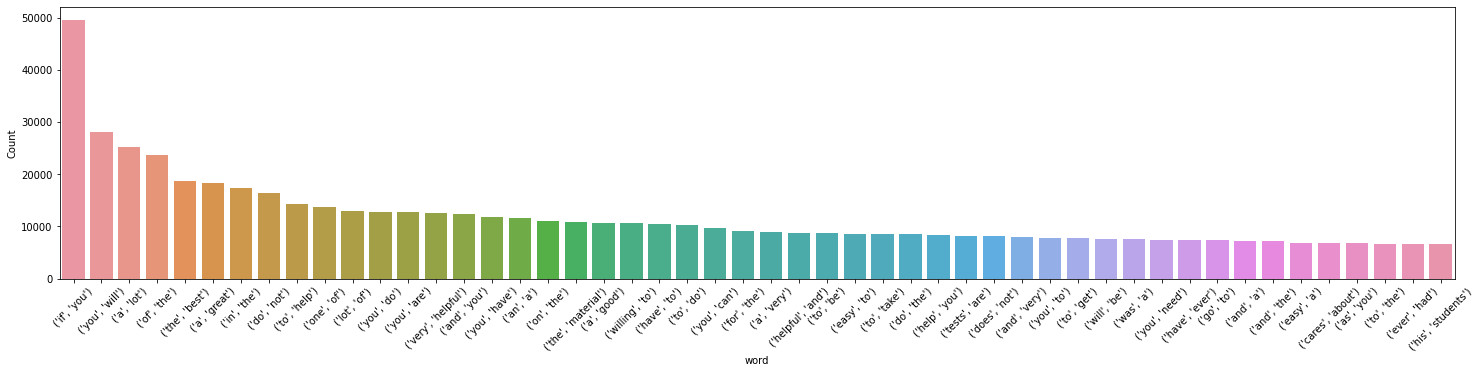

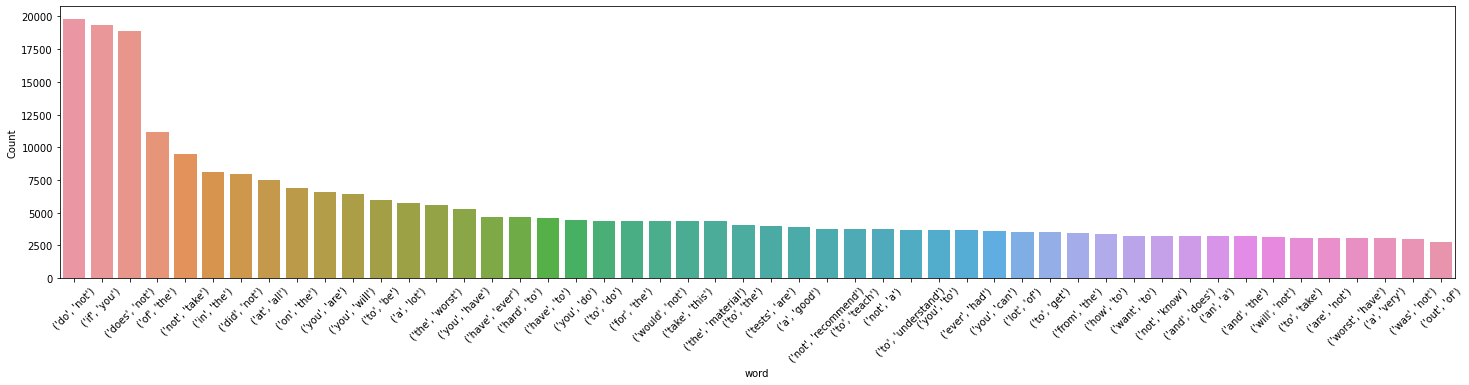

In [ ]:
from nltk import FreqDist

%matplotlib inline
def freq_ngrams(x, terms=40, n=1):        # function to plot most frequent n-grams
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    ngs = nltk.ngrams(all_words, n)
    fdist = FreqDist(ngs)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})

    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(25,5))
    plt.xticks(rotation=45)
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_ngrams(positive_reviews['cleanedComment'], terms=50, n=2)
freq_ngrams(negative_reviews['cleanedComment'], terms=50, n=2)

In [ ]:
# print(cv.stop_words_)
# print(len(cv.stop_words_))

In [ ]:
all_words = set()
for comment in reviews['cleanedComment']:
  unique_words_comment = set(comment.split(' '))
  all_words.update(unique_words_comment)


In [ ]:
len(all_words) # 52002

53093

# Validating (or Testing???)

In [ ]:
test_reviews = pd.read_csv("/content/drive/MyDrive/RMP/scraped_comments.csv").sample(n=120000, random_state=1)

In [ ]:
print("Shape before dropping:", test_reviews.shape)
test_reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

# drop rows containing only "No Comments" (default value assigned by RMP to a review that didn't enter a comment)
test_reviews = test_reviews[test_reviews["comment"] != "No Comments"]

# drop rows containing NaN comment
test_reviews.dropna(subset=["comment"], inplace=True)

# fill null names with empty string
test_reviews['firstName'].fillna('', inplace=True)
test_reviews['lastName'].fillna('', inplace=True)

# Dropping test_reviews with qualityRating == 3
test_reviews['qualityRating'] = (test_reviews['helpfulRating']+test_reviews['clarityRating'])/2.0
test_reviews = test_reviews[test_reviews["qualityRating"] != 3.0]
test_reviews["sentiment"] = test_reviews["qualityRating"] > 3.0

print("Shape after dropping:", test_reviews.shape)
test_reviews.reset_index(drop=True, inplace=True)

Shape before dropping: (120000, 16)
Shape after dropping: (106780, 18)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
comments_proper = []
spellchecked_comments = []

comments_proper = preprocess_pipeline(test_reviews)

25000
50000
75000
100000


In [ ]:
len(comments_proper)

106780

In [ ]:
sent_predA = sent_pipeline.predict(comments_proper)

In [ ]:
ones = sum(sent_pred)
zeroes = sum((i == 0 for i in sent_predA))
print(ones, zeroes, ones+zeroes)

37512 31087 68599


In [ ]:
len(sent_predA)

106780

In [ ]:
test_reviews.reset_index(inplace=True, drop=True)

## Accuracy

In [ ]:
evalPerformance(sent_predA, test_reviews['sentiment'])
'''
Precision Score: 91.96648216482166
Recall Score: 95.62749800159872
F1 Score: 91.05450458887432

Precision Score: 92.22649369350836
Recall Score: 95.56488142819079
F1 Score: 91.22026596740963
Accuracy Score: 91.22026596740963

Precision Score: 93.94723228142783
Recall Score: 94.35651478816946
F1 Score: 91.75969282637197
'''

Precision Score: 93.66520021666469
Recall Score: 94.45510258459898
F1 Score: 91.61172504214272
Accuracy Score: 91.61172504214272
[[26925  4795]
 [ 4162 70898]]


'\nPrecision Score: 91.96648216482166\nRecall Score: 95.62749800159872\nF1 Score: 91.05450458887432\n\nPrecision Score: 92.22649369350836\nRecall Score: 95.56488142819079\nF1 Score: 91.22026596740963\nAccuracy Score: 91.22026596740963\n\nPrecision Score: 93.94723228142783\nRecall Score: 94.35651478816946\nF1 Score: 91.75969282637197\n'

In [ ]:
right = sum(a == b for a, b in zip(sent_predA, test_reviews['sentiment']))
right / len(sent_predA)

0.9161172504214272

# Possible Improvements
* Could engineer new features using words that are capitalized in the review
* Remove reviews that're not english